In [120]:
import data.cifar100 as cifar100
from data.cifar100 import CIFARDataset, CIFARData
from  main_supcon_ood import set_loader, set_model
from pretraining.util import TwoCropTransform, AverageMeter
from pretraining.networks.resnet_big import SupConResNet
import seaborn as sns
from sklearn import manifold
import torch
import numpy as np
import matplotlib.pyplot as plt
import protonet
import util
# from protonet import *
from importlib import reload
from torchvision import transforms
reload(util)
reload(cifar100)
reload(protonet)
# %matplotlib widget

<module 'protonet' from '/home/advaya/CS330-Project/protonet.py'>

In [18]:
seen_train_dataset = cifar100.CIFARDataset(root = 'data/cifar10-dataset', 
                                class_partition='seen',
                                partition='train')
seen_val_dataset = cifar100.CIFARDataset(root = 'data/cifar10-dataset', 
                                class_partition='seen',
                                partition='val')
new_train_dataset = cifar100.CIFARDataset(root = 'data/cifar10-dataset', 
                                class_partition='new',
                                partition='train')
new_val_dataset = cifar100.CIFARDataset(root = 'data/cifar10-dataset', 
                                class_partition='new',
                                partition='val')
new_test_dataset = cifar100.CIFARDataset(root = 'data/cifar10-dataset', 
                                class_partition='new',
                                partition='test')
unseen_test_dataset = cifar100.CIFARDataset(root = 'data/cifar10-dataset', 
                                class_partition='unseen',
                                partition='test')  

seen_train_dataset_100 = cifar100.CIFARDataset(root = 'data/cifar-dataset', 
                                class_partition='seen',
                                partition='train')
# seen_pretrain_dataset = CIFARDataset(root = 'data/cifar10-dataset', 
#                                 class_partition='seen',
#                                 partition='pretrain')
print(seen_val_dataset.labels.shape)                                                                                              

(7200,)


In [19]:
train_sampler = None
seen_train_loader = torch.utils.data.DataLoader(
    seen_train_dataset, batch_size=128, shuffle=(train_sampler is None),
    num_workers=4, pin_memory=True, sampler=train_sampler)
seen_val_loader = torch.utils.data.DataLoader(
    seen_val_dataset, batch_size=128, shuffle=(train_sampler is None),
    num_workers=4, pin_memory=True, sampler=train_sampler)
new_train_loader = torch.utils.data.DataLoader(
    new_train_dataset, batch_size=128, shuffle=(train_sampler is None),
    num_workers=4, pin_memory=True, sampler=train_sampler)    

seen_train_loader_100 = torch.utils.data.DataLoader(
    seen_train_dataset_100, batch_size=128, shuffle=(train_sampler is None),
    num_workers=4, pin_memory=True, sampler=train_sampler)
# seen_pretrain_loader = torch.utils.data.DataLoader(
#     seen_pretrain_dataset, batch_size=128, shuffle=(train_sampler is None),
#     num_workers=4, pin_memory=True, sampler=train_sampler)

In [4]:
model = SupConResNet(name='resnet18',feat_dim=2048).cuda()

print('==> Loading model...')
# checkpoint = torch.load('pretrained_models/ckpt_epoch_250.pth')
checkpoint = torch.load('save/SupCon/cifar100_models/SupCon_cifar10_resnet18_lr_0.5_decay_0.0001_bsz_2048_temp_0.1_embdim_2048_trial_0_partition_train_data/cifar10-dataset_cosine_warm/ckpt_epoch_100.pth')
model.load_state_dict(checkpoint['model'])


==> Loading model...


<All keys matched successfully>

In [97]:
torch.cuda.empty_cache()
model.eval()

# for seen_val
preds = []
labels = []
with torch.no_grad():
    for batch_images, batch_labels in seen_train_loader:
    # for batch_images, batch_labels in seen_pretrain_loader:
        out = model(batch_images.permute(0,3,1,2).float().cuda())
        # print(out.cpu().numpy().shape)
        preds.extend(out.cpu().numpy())
        labels.extend(batch_labels.cpu().numpy().flatten())
        # del out     
preds = np.array(preds)
labels = np.array(labels)        

In [98]:
np.random.seed(1234)
# list_classes = list(range(10)) # [1,17]#list(range(60))#[1,16,17,31,32]
# list_classes = [ 9, 20, 32, 41, 50]
# list_classes = [1,16,17,31,32]
# list_classes = np.random.choice(list(range(60)), 5)
list_classes = list(np.unique(labels))

# list_classes = np.random.randint(0,60,3)
print(list_classes)
inds = [l in list_classes for l in labels]
print(len(inds))

[0, 1, 2, 3, 4, 5]
21600


In [106]:
pred_tsne = manifold.TSNE(n_components=2, learning_rate='auto',
        init='random', n_iter=1500, perplexity=10.0).fit_transform(preds[:5000])

[Text(0.5, 1.0, 'CIFAR data T-SNE projection')]

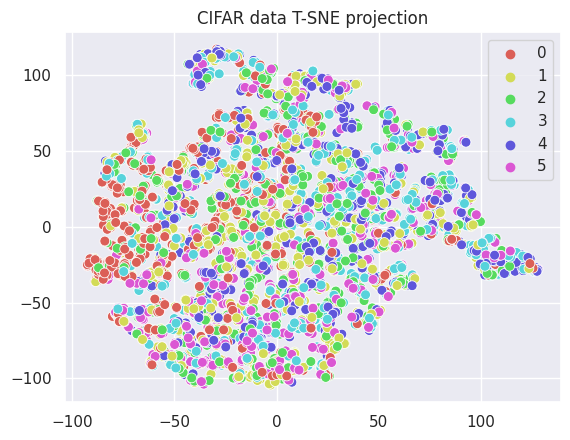

In [107]:
sns.scatterplot(x=pred_tsne[:5000,0], y=pred_tsne[:5000,1], hue=labels[:5000],
                palette=sns.color_palette("hls", len(list_classes)), legend=True,
                alpha=1,s=50).set(title="CIFAR data T-SNE projection")

/tmp/ipykernel_453725/3928209233.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


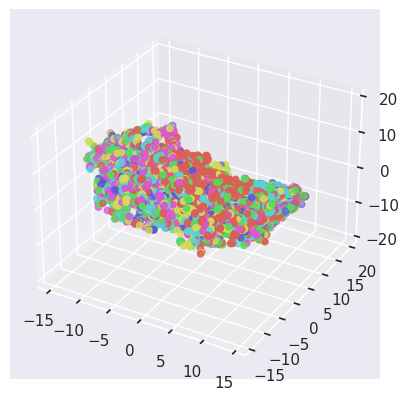

In [108]:
from matplotlib.colors import ListedColormap
pred_tsne = manifold.TSNE(n_components=3, learning_rate='auto',
        init='random', n_iter=1000).fit_transform(preds[:5000])
fig = plt.figure()
sns.set(style = "darkgrid")
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(pred_tsne[:5000,0], pred_tsne[:5000,1], pred_tsne[:5000,2], c=labels[:5000], cmap = ListedColormap(sns.color_palette("hls", len(list_classes))))
# ax.show()
fig.show()

In [110]:
out.shape

torch.Size([96, 2048])

In [21]:
list_classes = list(range(6))
prototypes = {cls: torch.zeros(2048, requires_grad=False).cuda() for cls in list_classes}
class_sizes = {cls: 0 for cls in list_classes}
model.eval()
preds = []
labels = []
for batch_images, batch_labels in seen_train_loader:
    out = model(batch_images.permute(0,3,1,2).float().cuda()).detach()
    for cls in list_classes:
        inds = batch_labels == cls
        prototypes[cls] += out[inds[:,0]].sum(axis=0)
        class_sizes[cls] += out[inds[:, 0]].shape[0]

prototypes_avg = {lab: (prototypes[lab]/class_sizes[lab]).cpu() for lab in list_classes}
for batch_images, batch_labels in seen_val_loader:
    out = model(batch_images.permute(0,3,1,2).float().cuda()).detach()
    preds.extend(out.cpu().numpy())
    labels.extend(batch_labels.cpu().flatten().numpy())
        # del out     



/tmp/ipykernel_834901/3553831639.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prototype_arr[lab] = torch.tensor(prototype)


[Text(0.5, 1.0, 'CIFAR data T-SNE projection')]

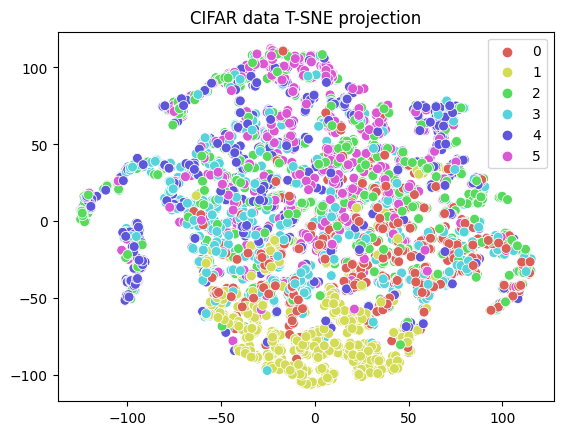

In [22]:
# prototype_lst = np.array(list(prototypes_avg.values()))
# prototypes_avg = {lab: (prototypes[lab]/class_sizes[lab]).cpu() for lab in list_classes}
preds = torch.tensor(np.array(preds))
labels = torch.tensor(np.array(labels))
prototype_arr = torch.zeros((len(list_classes), 2048))
for lab, prototype in prototypes_avg.items():
    prototype_arr[lab] = torch.tensor(prototype)
# pred_tsne_protos = manifold.TSNE(n_components=2, learning_rate='auto',
#         init='random', n_iter=1000, perplexity=5.0).fit_transform(prototype_arr)
# # fig, ax = plt.subplots()
# sns.scatterplot(x=pred_tsne_protos[:,0], y=pred_tsne_protos[:,1], hue=list_classes,
#                 palette=sns.color_palette("hls", len(list_classes)), legend=True,
#                 alpha=1,s=50,marker='x', size=100).set(title="CIFAR data T-SNE projection")
pred_tsne = manifold.TSNE(n_components=2, learning_rate='auto',
        init='random', n_iter=1500, perplexity=10.0).fit_transform(preds[:5000])
sns.scatterplot(x=pred_tsne[:5000,0], y=pred_tsne[:5000,1], hue=labels[:5000],
                palette=sns.color_palette("hls", len(list_classes)), legend=True,
                alpha=1,s=50).set(title="CIFAR data T-SNE projection")

In [23]:
diffs = (prototype_arr.unsqueeze(1) - preds.unsqueeze(0)).norm(dim=-1)
pred_labels = diffs.argmin(axis=0)
print((pred_labels == labels).float().mean().item())
for lab in list_classes:
    print(lab, (pred_labels[labels == lab] == labels[labels == lab]).float().mean().item())

0.35208332538604736
0 0.2789115607738495
1 0.991909384727478
2 0.08564231544733047
3 0.23562753200531006
4 0.2091221958398819
5 0.2874999940395355


In [19]:
print(prototype_arr.norm(dim=1).mean())
print(preds.norm(dim=1).mean())
(torch.tensor(np.random.choice(list_classes, 7200)) == labels).float().mean()

tensor(0.9770)
tensor(1.)


tensor(0.1675)

[Text(0.5, 1.0, 'CIFAR data T-SNE projection')]

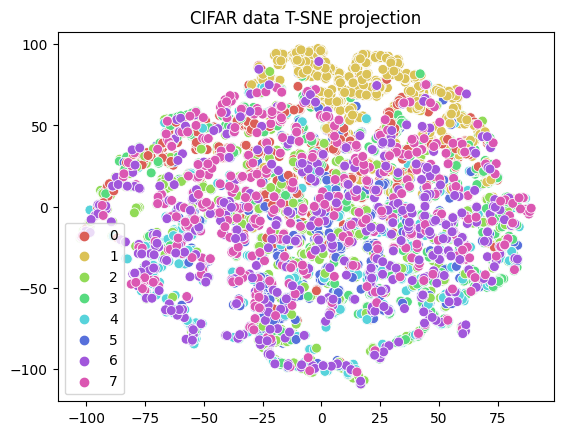

In [31]:
new_preds = []
new_labels = []
for batch_images, batch_labels in new_train_loader:
    out = model(batch_images.permute(0,3,1,2).float().cuda()).detach()
    new_preds.extend(out.cpu().numpy())
    new_labels.extend(batch_labels.cpu().flatten().numpy())
new_preds = torch.tensor(np.array(new_preds))
new_labels = torch.tensor(np.array(new_labels))

tsne_in = np.append(preds[:5000],new_preds[:1000], axis=0)
tsne_labels = np.append(labels[:5000],new_labels[:1000], axis=0)
pred_tsne_new = manifold.TSNE(n_components=2, learning_rate='auto',
        init='random', n_iter=1000, perplexity=10.0).fit_transform(tsne_in)
sns.scatterplot(x=pred_tsne_new[:,0], y=pred_tsne_new[:,1], hue=tsne_labels,
                palette=sns.color_palette("hls", len(np.unique(tsne_labels))), legend=True,
                alpha=1,s=50).set(title="CIFAR data T-SNE projection")

(6000,)

In [33]:
seen_val_dataset.merge_with(new_val_dataset)
seen_val_dataset.shuffle_labels = False

In [110]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
normalize = transforms.Normalize(mean=mean, std=std)
transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                normalize,
            ])

In [121]:
empty_enc = SupConResNet('resnet18', feat_dim=2048)
protonet_ = protonet.ProtoNetTrainer(empty_enc, 0.005, 0.01, 'logs/protonet/cifar10.support_eps:5.query_eps:15.support_novel:5.query_novel:15.eps_lr:0.01.novel_lr:0.001.batch_size:16')
protonet_.load(50, 'thres', 500)


Loaded checkpoint iteration thres50.


In [122]:
seen_val_dataset.switch_to_novel(support_size=10, num_novels_in_support=10, query_size=1500)
seen_val_dataset.transform = transform
dataloader_val = torch.utils.data.DataLoader(seen_val_dataset, batch_size=3, collate_fn=lambda x: x, pin_memory=torch.cuda.is_available())
with torch.no_grad():
    losses, accuracies_support, accuracies_query = [], [], []
    for _ in range(1):

        loss_batch = []
        accuracy_support_batch = []
        accuracy_query_batch = []
        task_batch = next(iter(dataloader_val))
        for task in task_batch:
            # print(task[-1])
            loss_task, accuracy_support_task, accuracy_query_task = protonet_.embd_train_step(task)
            loss_batch.append(loss_task)
            accuracy_query_batch.append(accuracy_query_task)
            accuracy_support_batch.append(accuracy_support_task)
        loss, accuracy_support, accuracy_query = (torch.mean(torch.stack(loss_batch)),
                                        np.mean(accuracy_support_batch),
                                        np.mean(accuracy_query_batch))
        losses.append(loss.item())
        accuracies_support.append(accuracy_support)
        accuracies_query.append(accuracy_query)
    loss = np.mean(losses)
    accuracy_support = np.mean(accuracies_support)
    accuracy_query = np.mean(accuracies_query)
    print(
    f'Validation: '
    f'loss: {loss:.3f}, '
    f'support accuracy: {accuracy_support:.3f}, '
    f'query accuracy: {accuracy_query:.3f}'
    )

0: 0.9893333315849304
1: 0.9979999661445618
2: 0.9419999718666077
3: 0.8233333230018616
4: 0.9046666622161865
5: 0.8673333525657654
6: 0.09066666662693024
7: 0.10733333230018616
0: 0.9879999756813049
1: 0.9953333139419556
2: 0.937999963760376
3: 0.8326666355133057
4: 0.9073333144187927
5: 0.8646666407585144
6: 0.09600000083446503
7: 0.07000000029802322
0: 0.9866666793823242
1: 0.9940000176429749
2: 0.9426666498184204
3: 0.8420000076293945
4: 0.9173333048820496
5: 0.859333336353302
6: 0.07466666400432587
7: 0.06466666609048843
Validation: loss: 1.113, support accuracy: 0.717, query accuracy: 0.712


In [127]:
seen_val_dataset.switch_to_epsilon(support_size=100, query_size=1500)
seen_val_dataset.transform = transform
dataloader_val = torch.utils.data.DataLoader(seen_val_dataset, batch_size=3, collate_fn=lambda x: x, pin_memory=torch.cuda.is_available())
with torch.no_grad():
    losses, accuracies_support, accuracies_query = [], [], []
    for _ in range(1):

        loss_batch = []
        accuracy_support_batch = []
        accuracy_query_batch = []
        task_batch = next(iter(dataloader_val))
        for task in task_batch:
            # print(task[-1])
            loss_task, accuracy_support_task, accuracy_query_task = protonet_.threshold_train_step(task, print_=True)
            loss_batch.append(loss_task)
            accuracy_query_batch.append(accuracy_query_task)
            accuracy_support_batch.append(accuracy_support_task)
        loss, accuracy_support, accuracy_query = (torch.mean(torch.stack(loss_batch)),
                                        np.mean(accuracy_support_batch),
                                        np.mean(accuracy_query_batch))
        losses.append(loss.item())
        accuracies_support.append(accuracy_support)
        accuracies_query.append(accuracy_query)
    loss = np.mean(losses)
    accuracy_support = np.mean(accuracies_support)
    accuracy_query = np.mean(accuracies_query)
    print(
    f'Validation: '
    f'loss: {loss:.3f}, '
    f'support accuracy: {accuracy_support:.3f}, '
    f'query accuracy: {accuracy_query:.3f}'
    )

0.0: 0.9777333736419678
1.0: 0.3611111044883728
0.0: 0.9637333154678345
1.0: 0.3464444577693939
0.0: 0.9725333452224731
1.0: 0.38466668128967285
Validation: loss: 0.725, support accuracy: 0.892, query accuracy: 0.744


In [75]:
model = protonet._network.encoder

In [106]:
torch.cuda.empty_cache()
